# Random Forest

In [ ]:
# import packages and load the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import os
from pyreadr import read_r
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import joblib

# Full Model: First, we want to fit the model with all features except x, y coordinates, and the expert label
Cross validation on image 1 and image 2 to tune the hyperparameters
we remove uncertain data to train the model, and we use the entire dataset for prediction 
for accuracy, we have to remove uncertain data also

In [13]:
image_1 = pd.read_csv("../../../data/image_data/image1.txt", delim_whitespace=True, header=None)
image_2 = pd.read_csv("../../../data/image_data/image2.txt", delim_whitespace=True, header=None)
image_3 = pd.read_csv("../../../data/image_data/image3.txt", delim_whitespace=True, header=None)

column_names = ['y_coor', 'x_coor', 'expert_label', 'NDAI', 'SD', 'CORR', 'Radiance_angle_DF','Radiance_angle_CF','Radiance_angle_BF','Radiance_angle_AF', 'Radiance_angle_AN'] 
image_1.columns = column_names
image_2.columns = column_names
image_3.columns = column_names


# remove when expert label is zero (remove uncertain data)
train_on1 = image_1[image_1['expert_label'] != 0]

# select all features except the expert_label column from dataset and call it x
#drop expert_label and x_coor, y_coor
#Don't use X and Y coordinates as features 
x_train1 = train_on1.drop(columns=['expert_label', 'x_coor', 'y_coor']) # explanatory variables
y_train1 = train_on1['expert_label'] # response variable we want to predict

# below are datasets we should use for caculating prediction accuracy using image 2
validate_on2 = image_2[image_2['expert_label'] != 0] # remove uncertain data

#drop expert_label and x_coor, y_coor
x_validate2 = validate_on2.drop(columns=['expert_label', 'x_coor', 'y_coor']) # explanatory variables
y_validate2 = validate_on2['expert_label'] # response variable we want to predict

/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_4617/4023613531.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_1 = pd.read_csv("../../../data/image_data/image1.txt", delim_whitespace=True, header=None)
/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_4617/4023613531.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_2 = pd.read_csv("../../../data/image_data/image2.txt", delim_whitespace=True, header=None)
/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_4617/4023613531.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_3 = pd.read_csv("../../../data/image_data/image3.txt", delim_whitespace=True, header=None)


In [ ]:
# Below is just testing my code using the default parameters, can ignore 
rf = RandomForestClassifier()
rf.fit(x_train1, y_train1)
#y_pred_on2 = rf.predict(image_2.drop(columns=['expert_label'])) #prediction using entire image 2 data
accuracy_model_1 = rf.score(x_validate2, y_validate2) #accuracy of the model (have to drop )

from sklearn.metrics import classification_report
print(classification_report(y_validate2, rf.predict(x_validate2)))

features = pd.DataFrame(rf.feature_importances_, index=x_train1.columns, columns=['importance']).sort_values('importance', ascending=False)
features

## Now I try to pick the best hyperparameters through grid search. I tune the hyperparameters for the full model by running the trainhyper.py file on SCF. The results for the best hyperparameters in the full model are saved in results folder. The hyperparameter tuning process performed two fold validation: train on image 1 and test on image 2, train on image 2 and test on image 1. Roc_auc is the metric we used to select the best set of hyperparameters. 

In [65]:
#load csv file
hyper_p_results = pd.read_csv("../../../results/grid_search_results_full_model.csv") #this is the grid search result for choosing the hyperparameters
hyper_p_results=pd.DataFrame(hyper_p_results)
columns_to_drop=list(hyper_p_results.columns[:4])+[hyper_p_results.columns[10]]+list(hyper_p_results.columns[14:18])+list(hyper_p_results.columns[19:21])
hyper_p_results_dropped = hyper_p_results.drop(columns=columns_to_drop)
hyper_p_results_sorted =hyper_p_results_dropped.sort_values(by='mean_test_roc_auc', ascending=False)
# Display the first 6 rows of the hyper_p_results_sorted DataFrame in a Jupyter Notebook
hyper_p_results_sorted.head(6)

,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,split0_test_roc_auc,split1_test_roc_auc,mean_test_roc_auc,mean_test_accuracy
154,True,entropy,10.0,4,2,200,0.958449,0.928402,0.943425,0.848746
157,True,entropy,10.0,4,5,200,0.958449,0.928402,0.943425,0.848746
153,True,entropy,10.0,4,2,100,0.957512,0.928838,0.943175,0.846947
156,True,entropy,10.0,4,5,100,0.957512,0.928838,0.943175,0.846947
155,True,entropy,10.0,4,2,300,0.958294,0.927949,0.943122,0.849589
158,True,entropy,10.0,4,5,300,0.958294,0.927949,0.943122,0.849589


In [44]:
hyper_p_results2 = pd.read_csv("../../../results/results_parameter.csv") #this is the grid search result for choosing the hyperparameters

## best roc_auc: 0.9434
## best hyperparameters: "{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}"
## random state=42

# Now we use the best set of parameters to perform modeling on both image 1 and image 2 data combined

In [40]:
predict_on3 = image_3[image_3['expert_label'] != 0]   # remove uncertain data 

x_test3 = predict_on3.drop(columns=['expert_label', 'x_coor', 'y_coor']) # explanatory variables
y_test3 = predict_on3['expert_label'] # response variable we want to predict

In [31]:
rf_best_hyper = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=2, min_samples_leaf=4, bootstrap=True, criterion='entropy', random_state=42)
x_combined_train = pd.concat([x_train1, x_validate2])
y_combined_train = pd.concat([y_train1, y_validate2])

In [41]:
rf_best_hyper.fit(x_combined_train, y_combined_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,
                       n_estimators=200, random_state=42)

In [42]:
# Check both training and test accuracy using default hyperparameters
train_accuracy = rf_best_hyper.score(x_combined_train, y_combined_train)

test_accuracy = rf_best_hyper.score(x_test3, y_test3)

print("Training accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

Training accuracy: 0.9679482572763205
Test accuracy: 0.47627100152738383


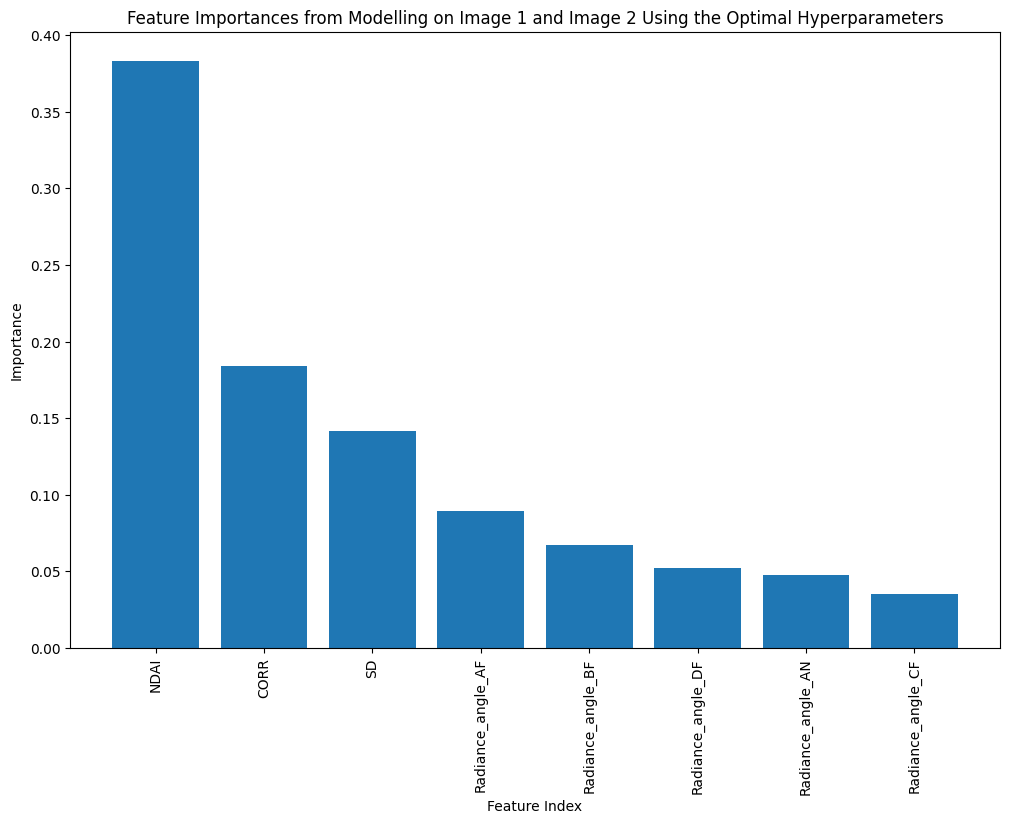

In [66]:
features = pd.DataFrame(rf_best_hyper.feature_importances_, index=x_combined_train.columns, columns=['importance']).sort_values('importance', ascending=False)
features

plt.figure(figsize=(12, 8))
plt.bar(features.index, features['importance'])
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances from Modelling on Image 1 and Image 2 Using the Optimal Hyperparameters')
plt.xticks(ticks=features.index, rotation=90)
plt.show()

# Prediction using Testing set: Image 3

In [18]:
from sklearn.metrics import classification_report

# remove when expert label is zero (remove uncertain data)
predict_on3 = image_3[image_3['expert_label'] != 0]   

print(classification_report(predict_on3['expert_label'], rf_best_hyper.predict(predict_on3.drop(columns=['expert_label', 'x_coor', 'y_coor']))))

              precision    recall  f1-score   support

        -1.0       0.78      0.20      0.32     33752
         1.0       0.42      0.91      0.57     21244

    accuracy                           0.48     54996
   macro avg       0.60      0.56      0.45     54996
weighted avg       0.64      0.48      0.42     54996



In [22]:
# Accuracy score 
from sklearn.metrics import accuracy_score
# Assuming rf_best_hyper1 is your trained Random Forest model
y_pred_on3 = rf_best_hyper.predict(predict_on3.drop(columns=['expert_label', 'x_coor', 'y_coor']))
y_true_on3 = predict_on3['expert_label']

accuracy = accuracy_score(y_true_on3, y_pred_on3)
print(f'Prediction Accuracy on predict_on3: {accuracy}')

Prediction Accuracy on predict_on3: 0.47627100152738383


ROC_AUC when predicting using image 3: 0.6241021264724512


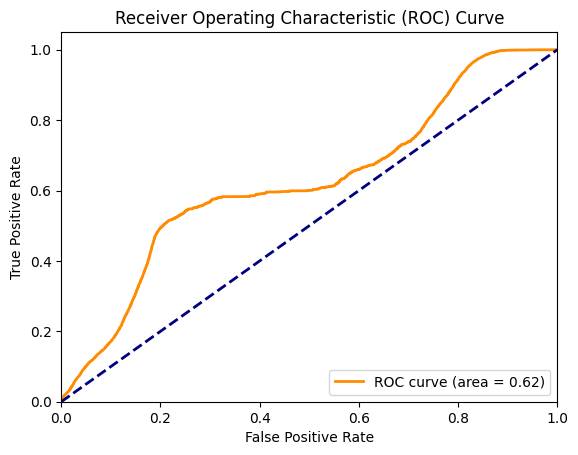

In [51]:
# Prediction Probabbility 
# For ROC AUC, we need the prediction probabilities for the positive class
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
y_pred_prob_on3 = rf_best_hyper.predict_proba(predict_on3.drop(columns=['expert_label', 'x_coor', 'y_coor']))[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_true_on3, y_pred_prob_on3)
print(f'ROC_AUC when predicting using image 3: {roc_auc}')

fpr, tpr, thresholds = roc_curve(y_true_on3, y_pred_prob_on3)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


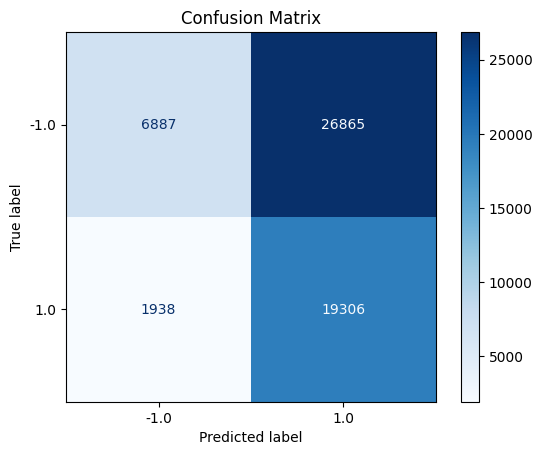

In [67]:
#predict using rf_best_hyper1 on image 2 data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix1 = confusion_matrix(predict_on3['expert_label'], rf_best_hyper.predict(predict_on3.drop(columns=['expert_label', 'x_coor', 'y_coor'])))
confusion_matrix1

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix1, display_labels=rf_best_hyper.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Reduced Model: Secondly, we want to fit the model with only the top 3 features with the most importance
Cross validation on image 1 and image 2 to tune the hyperparameters
we remove uncertain data to train the model, and we use the entire dataset for prediction 
for accuracy, we have to remove uncertain data also

In [73]:
# remove when expert label is zero (remove uncertain data)
train_on1 = image_1[image_1['expert_label'] != 0]

# select all features except the expert_label column from dataset and call it x
#drop expert_label and x_coor, y_coor
#Don't use X and Y coordinates as features 
selected_col = ['NDAI', 'SD', 'CORR']
x_train_redc = train_on1[selected_col] # explanatory variables
y_train_redc = train_on1['expert_label'] # response variable we want to predict

# below are datasets we should use for caculating prediction accuracy using image 2
validate_on2 = image_2[image_2['expert_label'] != 0] # remove uncertain data

#drop expert_label and x_coor, y_coor
x_validate_redc = validate_on2[selected_col] # explanatory variables
y_validate_redc = validate_on2['expert_label'] # response variable we want to predict

## Now I try to pick the best hyperparameters for the reduced model through grid search. I tune the hyperparameters for the full model by running the trainhyper.py file on SCF. The results for the best hyperparameters in the full model are saved in results folder. The hyperparameter tuning process performed two fold validation: train on image 1 and test on image 2, train on image 2 and test on image 1. Roc_auc is the metric we used to select the best set of hyperparameters. 

In [70]:
# load the hyperparameter tuning results 
#load csv file
hyper_p_results2 = pd.read_csv("../../../results/grid_search_results_red_model.csv") #this is the grid search result for choosing the hyperparameters
hyper_p_results2=pd.DataFrame(hyper_p_results2)
columns_to_drop=list(hyper_p_results2.columns[:4])+[hyper_p_results2.columns[10]]+list(hyper_p_results2.columns[14:18])+list(hyper_p_results2.columns[19:21])
hyper_p_results_dropped = hyper_p_results2.drop(columns=columns_to_drop)
hyper_p_results_sorted =hyper_p_results_dropped.sort_values(by='mean_test_roc_auc', ascending=False)
# Display the first 6 rows of the hyper_p_results_sorted DataFrame in a Jupyter Notebook
hyper_p_results_sorted.head(6)

,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,split0_test_roc_auc,split1_test_roc_auc,mean_test_roc_auc,mean_test_accuracy
249,False,gini,10.0,1,10,100,0.960679,0.962640,0.961659,0.882606
246,False,gini,10.0,1,5,100,0.959472,0.962492,0.960982,0.881813
250,False,gini,10.0,1,10,200,0.958789,0.962742,0.960765,0.883120
247,False,gini,10.0,1,5,200,0.958772,0.962683,0.960727,0.882025
362,False,entropy,10.0,2,2,300,0.960544,0.960816,0.960680,0.882722
248,False,gini,10.0,1,5,300,0.958471,0.962656,0.960563,0.882116


In [72]:
hyper_para_results = pd.read_csv("../../../results/results_parameter_red.csv") #this is the grid search result for choosing the hyperparameters
print(hyper_para_results)

   best_roc_auc  best_accuracy  \
0      0.961659       0.883852   

                                         best_params  
0  {'bootstrap': False, 'criterion': 'gini', 'max...  


## The best set of hyperparameters for the reduced model is: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
## best_roc__auc: 0.96
## best_accuracy: 0.88

# Now we use the best set of parameters to perform modeling on both image 1 and image 2 data combined

In [74]:
predict_on3 = image_3[image_3['expert_label'] != 0]   # remove uncertain data 
selected_col = ['NDAI', 'SD', 'CORR']

x_test3 = predict_on3[selected_col] # explanatory variables
y_test3 = predict_on3['expert_label'] # response variable we want to predict

In [75]:
rf_best_hyper_red = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=1, bootstrap=False, criterion='gini', random_state=42)
x_combined_train = pd.concat([x_train_redc, x_validate_redc])
y_combined_train = pd.concat([y_train_redc, y_validate_redc])

In [76]:
rf_best_hyper_red.fit(x_combined_train, y_combined_train)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=10,
                       random_state=42)

In [77]:
# Check both training and test accuracy using default hyperparameters
train_accuracy = rf_best_hyper_red.score(x_combined_train, y_combined_train)

test_accuracy = rf_best_hyper_red.score(x_test3, y_test3)

print("Training accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

Training accuracy: 0.9564172083755267
Test accuracy: 0.8129682158702451


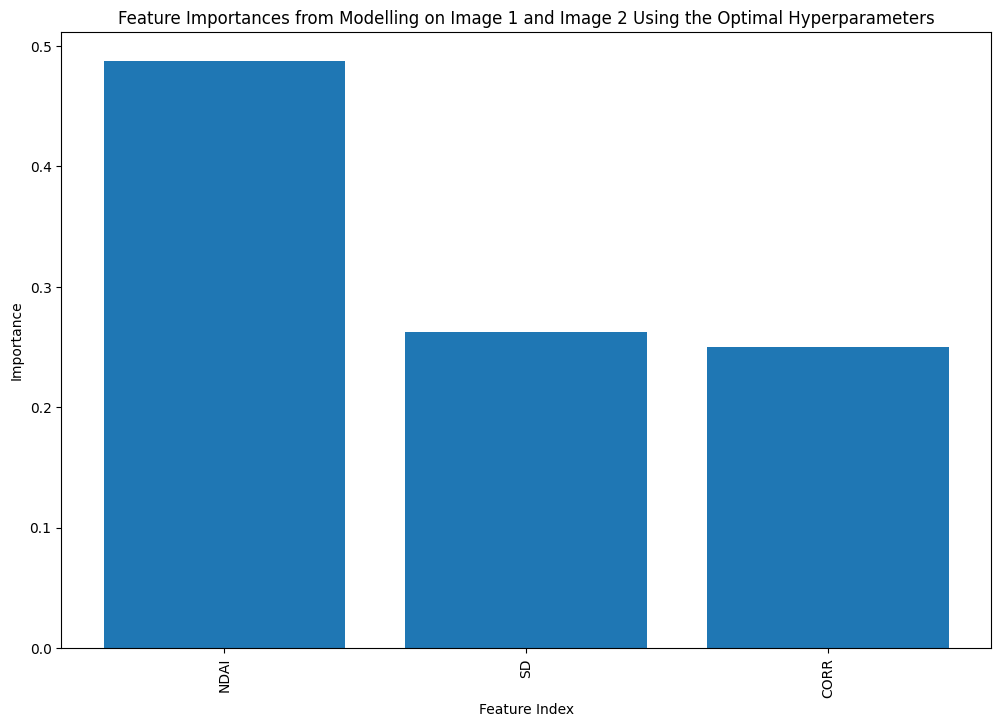

In [78]:
features = pd.DataFrame(rf_best_hyper_red.feature_importances_, index=x_combined_train.columns, columns=['importance']).sort_values('importance', ascending=False)
features

plt.figure(figsize=(12, 8))
plt.bar(features.index, features['importance'])
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances from Modelling on Image 1 and Image 2 Using the Optimal Hyperparameters')
plt.xticks(ticks=features.index, rotation=90)
plt.show()

# Prediction using reduced model on Test set: Image 3

In [79]:
from sklearn.metrics import classification_report

# remove when expert label is zero (remove uncertain data)
predict_on3 = image_3[image_3['expert_label'] != 0]   

print(classification_report(predict_on3['expert_label'], rf_best_hyper_red.predict(predict_on3[selected_col])))

              precision    recall  f1-score   support

        -1.0       0.84      0.85      0.85     33752
         1.0       0.76      0.75      0.76     21244

    accuracy                           0.81     54996
   macro avg       0.80      0.80      0.80     54996
weighted avg       0.81      0.81      0.81     54996



ROC_AUC when predicting using image 3: 0.9045546005622591


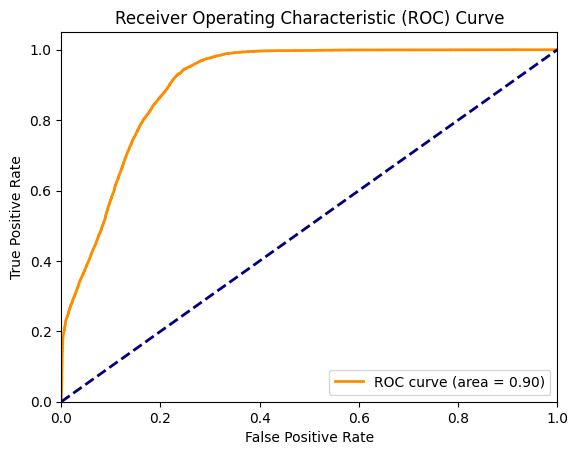

In [80]:
# Prediction Probabbility 
# For ROC AUC, we need the prediction probabilities for the positive class
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
y_true_on3 = predict_on3['expert_label']
y_pred_prob_on3 = rf_best_hyper_red.predict_proba(predict_on3[selected_col])[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_true_on3, y_pred_prob_on3)
print(f'ROC_AUC when predicting using image 3: {roc_auc}')

fpr, tpr, thresholds = roc_curve(y_true_on3, y_pred_prob_on3)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

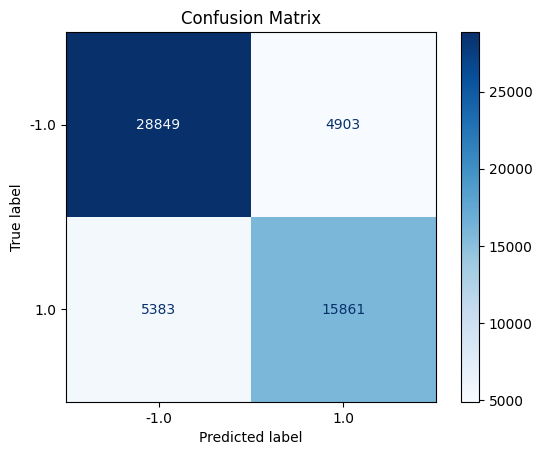

In [81]:
#predict using rf_best_hyper1 on image 2 data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix1 = confusion_matrix(predict_on3['expert_label'], rf_best_hyper_red.predict(predict_on3[selected_col]))
confusion_matrix1

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix1, display_labels=rf_best_hyper_red.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# below is just testing my python script for tuning hyperparameters for SCF, can ignore

In [1]:
# import packages and load the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import os
from pyreadr import read_r
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import joblib

image_1 = pd.read_csv("../../../data/image_data/image1.txt", delim_whitespace=True, header=None)
image_2 = pd.read_csv("../../../data/image_data/image2.txt", delim_whitespace=True, header=None)
image_3 = pd.read_csv("../../../data/image_data/image3.txt", delim_whitespace=True, header=None)

column_names = ['y_coor', 'x_coor', 'expert_label', 'NDAI', 'SD', 'CORR', 'Radiance_angle_DF','Radiance_angle_CF','Radiance_angle_BF','Radiance_angle_AF', 'Radiance_angle_AN'] 
image_1.columns = column_names
image_2.columns = column_names
image_3.columns = column_names


# remove when expert label is zero (remove uncertain data)
train_on1 = image_1[image_1['expert_label'] != 0]

# select all features except the expert_label column from dataset and call it x
#drop expert_label and x_coor, y_coor
#Don't use X and Y coordinates as features 
x_train1 = train_on1.drop(columns=['expert_label', 'x_coor', 'y_coor']) # explanatory variables
y_train1 = train_on1['expert_label'] # response variable we want to predict

# below are datasets we should use for caculating prediction accuracy using image 2
validate_on2 = image_2[image_2['expert_label'] != 0] # remove uncertain data

#drop expert_label and x_coor, y_coor
x_validate2 = validate_on2.drop(columns=['expert_label', 'x_coor', 'y_coor']) # explanatory variables
y_validate2 = validate_on2['expert_label'] # response variable we want to predict

# Try to tune the hyperparameters using gridsearch and cross validation (train on 1 and validate on 2)
rf = RandomForestClassifier(random_state=42)
param_grid = {
'n_estimators': [100, 200, 300], # number of trees in the forest, default=100. usually more trees better performance
#'max_depth': [None, 10, 20, 30], # the maximum depth of the tree, default=none. may lead to overfitting if the depth too large
#'min_samples_split': [2, 5, 10], # the minimum number of samples required to split an internal node, default=2 (the node will split as long as it has at least 2 samples). high values prevent overfitting
#'min_samples_leaf': [1, 2, 4], # the minimum number of samples required to be at a leaf node, default=1. large values prevent overfitting
#'criterion': ['gini', 'entropy'], # the function to measure the quality of a split, default=gini. 
#'bootstrap': [True, False] # whether bootstrap samples are used when building trees, default=True
}

# Create a validation fold
X = pd.concat([x_train1, x_validate2], ignore_index=True)
y = pd.concat([y_train1, y_validate2], ignore_index=True)

# Create test_fold array for both splits simultaneously
test_fold = np.ones(len(X))  # Initialize with 1s (won't be used in CV)
test_fold[:len(x_train1)] = 0  # Elements with 0 are treated as validation data in split 1.
test_fold[len(x_train1):] = 1  # Elements with 1 are treated as validation data in split 2.
#should not use "-1" index because it will always be training. 
# With 0, 1 index, cv in Gridsearchcv will consider two scenarios: 0 as training and 1 as validation, and 1 as training and 0 as validation

# Create PredefinedSplit object
ps = PredefinedSplit(test_fold)

# Define multiple scoring metrics
scoring = {
    'roc_auc': 'roc_auc',        # Area Under the ROC Curve
    'accuracy': 'accuracy'      # Accuracy score
}

# Use GridSearchCV with the combined predefined split
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           cv=ps, 
                           refit='roc_auc', # Specify which metric to use for choosing the best model
                           n_jobs=-1)

# Fit the model with combined data
grid_search.fit(X, y)

# Access and print the results
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('grid_search_results_full_model.csv', index=False)
best_roc_auc = grid_search.cv_results_['mean_test_roc_auc'].max()
best_accuracy = grid_search.cv_results_['mean_test_accuracy'].max()
best_params=grid_search.best_params_
# Create a dictionary to hold the best parameters and score
results_parameter = {
   'best_roc_auc': [best_roc_auc],
   'best_accuracy': [best_accuracy],
   'best_params': [best_params]
}

results_parameter = pd.DataFrame(results_parameter)
results_parameter.to_csv('results_parameter.csv', index=False)

# Save the best model
#joblib.dump(best_rf, 'best_random_forest_model.pkl')

/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_6972/644532051.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_1 = pd.read_csv("../../../data/image_data/image1.txt", delim_whitespace=True, header=None)
/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_6972/644532051.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_2 = pd.read_csv("../../../data/image_data/image2.txt", delim_whitespace=True, header=None)
/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_6972/644532051.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_3 = pd.read_csv("../../../data/image_data/image3.txt", delim_whitespace=True, header=None)
/opt/miniconda3/envs/215a/lib/pyth

In [68]:
# import packages and load the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import os
from pyreadr import read_r
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import joblib

image_1 = pd.read_csv("../../../data/image_data/image1.txt", delim_whitespace=True, header=None)
image_2 = pd.read_csv("../../../data/image_data/image2.txt", delim_whitespace=True, header=None)
image_3 = pd.read_csv("../../../data/image_data/image3.txt", delim_whitespace=True, header=None)

column_names = ['y_coor', 'x_coor', 'expert_label', 'NDAI', 'SD', 'CORR', 'Radiance_angle_DF','Radiance_angle_CF','Radiance_angle_BF','Radiance_angle_AF', 'Radiance_angle_AN'] 
image_1.columns = column_names
image_2.columns = column_names
image_3.columns = column_names


# remove when expert label is zero (remove uncertain data)
train_on1 = image_1[image_1['expert_label'] != 0]

# select all features except the expert_label column from dataset and call it x
#drop expert_label and x_coor, y_coor
#Don't use X and Y coordinates as features 
selected_col = ['NDAI', 'SD', 'CORR']
x_train_redc = train_on1[selected_col] # explanatory variables
y_train_redc = train_on1['expert_label'] # response variable we want to predict

# below are datasets we should use for caculating prediction accuracy using image 2
validate_on2 = image_2[image_2['expert_label'] != 0] # remove uncertain data

#drop expert_label and x_coor, y_coor
x_validate_redc = validate_on2[selected_col] # explanatory variables
y_validate_redc = validate_on2['expert_label'] # response variable we want to predict


# Try to tune the hyperparameters using gridsearch and cross validation (train on 1 and validate on 2)
rf = RandomForestClassifier(random_state=42)
param_grid = {
'n_estimators': [100, 200, 300], # number of trees in the forest, default=100. usually more trees better performance
#'max_depth': [None, 10, 20, 30], # the maximum depth of the tree, default=none. may lead to overfitting if the depth too large
#'min_samples_split': [2, 5, 10], # the minimum number of samples required to split an internal node, default=2 (the node will split as long as it has at least 2 samples). high values prevent overfitting
#'min_samples_leaf': [1, 2, 4], # the minimum number of samples required to be at a leaf node, default=1. large values prevent overfitting
#'criterion': ['gini', 'entropy'], # the function to measure the quality of a split, default=gini. 
#'bootstrap': [True, False] # whether bootstrap samples are used when building trees, default=True
}

# Create a validation fold
X = pd.concat([x_train_redc, x_validate_redc], ignore_index=True)
y = pd.concat([y_train_redc, y_validate_redc], ignore_index=True)

# Create test_fold array for both splits simultaneously
test_fold = np.ones(len(X))  # Initialize with 1s (won't be used in CV)
test_fold[:len(x_train_redc)] = 0  # Elements with 0 are treated as validation data in split 1.
test_fold[len(x_train_redc):] = 1  # Elements with 1 are treated as validation data in split 2.
#should not use "-1" index because it will always be training. 
# With 0, 1 index, cv in Gridsearchcv will consider two scenarios: 0 as training and 1 as validation, and 1 as training and 0 as validation

# Create PredefinedSplit object
ps = PredefinedSplit(test_fold)

# Define multiple scoring metrics
scoring = {
    'roc_auc': 'roc_auc',        # Area Under the ROC Curve
    'accuracy': 'accuracy'      # Accuracy score
}

# Use GridSearchCV with the combined predefined split
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           cv=ps, 
                           refit='roc_auc', # Specify which metric to use for choosing the best model
                           n_jobs=-1)

# Fit the model with combined data
grid_search.fit(X, y)

# Access and print the results
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('grid_search_results_full_model.csv', index=False)
best_roc_auc = grid_search.cv_results_['mean_test_roc_auc'].max()
best_accuracy = grid_search.cv_results_['mean_test_accuracy'].max()
best_params=grid_search.best_params_
# Create a dictionary to hold the best parameters and score
results_parameter = {
   'best_roc_auc': [best_roc_auc],
   'best_accuracy': [best_accuracy],
   'best_params': [best_params]
}

results_parameter = pd.DataFrame(results_parameter)
results_parameter.to_csv('results_parameter.csv', index=False)

# Save the best model
#joblib.dump(best_rf, 'best_random_forest_model.pkl')

/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_7780/3593411579.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_1 = pd.read_csv("../../../data/image_data/image1.txt", delim_whitespace=True, header=None)
/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_7780/3593411579.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_2 = pd.read_csv("../../../data/image_data/image2.txt", delim_whitespace=True, header=None)
/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_7780/3593411579.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_3 = pd.read_csv("../../../data/image_data/image3.txt", delim_whitespace=True, header=None)
